In [9]:
%reset-f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from res_ind_lib import *

from sorted_nicely import *
from replace_with_warning import *

import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)

In [11]:
import numpy as np
import pandas as pd

#Pandas display options
# pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.width', 200)
# pd.set_option('display.precision', 10)
# pd.set_option('display.max_rows', 500)

#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}
plt.rc('font', **font)

from fancy_plots import *

In [12]:
economy = "country" #province, deparmtent
event_level = [economy, "hazard", "rp"]

# Reading data 

In [17]:
macro = pd.read_csv("intermediate/macro.csv", index_col=economy).dropna()
macro.sample(n=2)

,gdp_pc_pp,pop,urbanization_rate,prepare_scaleup,borrow_abi,avg_prod_k,T_rebuild_K,pi,income_elast,rho,shareable,max_increased_spending,protection,tau_tax
country,,,,,,,,,,,,,,
Niger,897.395321,19899120.0,0.18732,0.666667,0.333333,0.233592,3,0.2,1.5,0.06,0.8,0.05,20.0,0.061743
Slovak Republic,28254.255793,5423801.0,0.53598,0.733333,0.625000,0.305902,3,0.2,1.5,0.06,0.8,0.05,20.0,0.392993


In [18]:
cat_info = pd.read_csv("intermediate/cat_info.csv",  index_col=[economy, "income_cat"]).dropna()
cat_info.sample(n=2)

,,n,c,axfin,gamma_SP,k,fa,v,shew
country,income_cat,,,,,,,,
"Iran, Islamic Rep.",poor,0.2,5620.641756,0.151668,0.672016,14898.408431,0.018325,0.7,0.32
Zambia,poor,0.2,686.243247,0.055189,0.309271,1513.387110,0.015701,0.7,0.64


In [19]:
hazard_ratios = pd.read_csv("intermediate/hazard_ratios.csv", index_col=event_level+["income_cat"]).dropna()
hazard_ratios.sample(n=2)

,,,,fa,shew
country,hazard,rp,income_cat,,
Niger,wind,1500.0,nonpoor,0.000000,0.6
Estonia,earthquake,250.0,poor,0.004149,0.0


# Computes and saves national resilience

In [20]:
#args = dict(hazard_ratios = hazard_ratios.unstack("hazard").swaplevel(0,1,axis="columns").flood, return_stats=True)
args = dict(hazard_ratios = hazard_ratios, return_stats=True)  # for final
#args = dict(hazard_ratios = None, return_stats=True)  
# args = dict(return_stats=True)  # for test
#args = dict()

results=compute_resilience(macro,cat_info,optionPDS="unif_poor", optionT="data",**args)


print("nb countries with macro data :" +str(macro.shape[0]))
print("nb countries with cat data :"   +str(cat_info.unstack().dropna().shape[0]))
print("nb countries with hazard data :"+str(hazard_ratios.unstack(["rp","hazard"]).dropna().shape[0]))

nb_countries_all_results = results["resilience"].dropna().shape[0]
print("nb countries with results :"+str(nb_countries_all_results))
results.to_csv("results/results.csv",float_format="%.5f")

#av_res = ((results["resilience"]*macro["pop"]).sum())/macro["pop"].sum()
av_res = results.dKtot.sum()/results.dWtot_currency.sum()
av_risk_asset = ((results["risk_to_assets"]*macro["pop"]).sum())/macro["pop"].sum()
av_risk_welfare = ((results["risk"]*macro["pop"]).sum())/macro["pop"].sum()

#Some stats
a=results.resilience;
print("Resilience averages {mean:.0%} across our sample, ranging from {min:.0%} to {max:.0%}".format(
        min=a.min(),mean=av_res,max=a.max()))

a=results.risk
print("Risk to welfare averages {mean:.03%} across our sample, ranging from {min:.03%} ({m}) to {max:.03%} ({M})".format(
    min=a.min(),mean=av_risk_welfare,max=a.max(),m=a.argmin(),M=a.argmax()))


a=results.risk_to_assets
print("Risk to assets averages {mean:.03%} across our sample, ranging from {min:.03%} ({m}) to {max:.03%} ({M})".format(
    min=a.min(),mean=av_risk_asset,max=a.max(),m=a.argmin(),M=a.argmax()))

print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= results.dWtot_currency.sum()*1e-9,
k= results.dKtot.sum()*1e-9,
r=results.dWtot_currency.sum()/results.dKtot.sum()))

results.ix[["Denmark", "Netherlands","Malawi", "Bangladesh", "Jamaica", "Congo, Dem. Rep.", "Finland"],["protection", "risk", "v","fa","resilience"]]

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
nb countries with macro data :126
nb countries with cat data :125
nb countries with hazard data :262
nb countries with results :124
Resilience averages 63% across our sample, ranging from 6% to 81%
Risk to welfare averages 0.267% across our sample, ranging from 0.000% (Norway) to 2.138% (Bhutan)
Risk to assets averages 0.164% across our sample, ranging from 0.001% (Zimbabwe) to 1.519% (Bhutan)
At the global scale, we estimate asset losses due to natural disasters to be 109 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.6 times bigger, at 173 bn$ per year


,protection,risk,v,fa,resilience
country,,,,,
Denmark,20.0,0.000042,1.300000,0.000751,0.802349
Netherlands,20.0,0.000732,1.339029,0.013140,0.784797
Malawi,20.0,0.009044,2.469789,0.068994,0.593718
Bangladesh,20.0,0.015398,2.362141,0.156590,0.660293
Jamaica,20.0,0.015708,2.265503,0.193342,0.560282
"Congo, Dem. Rep.",20.0,0.009832,3.100000,0.048437,0.519640
Finland,NaN,NaN,NaN,NaN,NaN


In [9]:
cormat = results[["gdp_pc_pp","risk_to_assets","resilience","risk"]]
cormat.corr()

,gdp_pc_pp,risk_to_assets,resilience,risk
gdp_pc_pp,1.000000,-0.287111,0.479294,-0.312895
risk_to_assets,-0.287111,1.000000,0.000397,0.965500
resilience,0.479294,0.000397,1.000000,-0.172281
risk,-0.312895,0.965500,-0.172281,1.000000


# Macro mulitplier

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


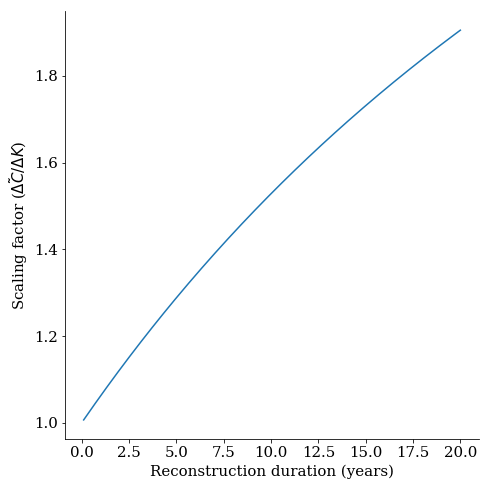

In [22]:
t= np.linspace(0,20,200)

three = np.log(1/0.05) 
recons_rate = three/ t

plt.figure(figsize=(7,7))

for mu in [.25]: 
    r=6/100

    g= (mu+recons_rate)/(r+recons_rate)

    plt.plot(t,g)

# l=plt.legend(["30%","20%","15%"],prop=font,title="Average \nproductivity \nof capital", loc=2, frameon=False)    
# plt.setp(l.get_title(), multialignment='center')    


plt.xlabel("Reconstruction duration (years)")
plt.ylabel("Scaling factor (${\Delta C}/{\Delta K}$)")


spine_and_ticks(plt.gca())

plt.savefig("img/macro_resilience.png")

plt.ylabel("Scaling factor (${\\tilde{\Delta C}}/{\Delta K}$)")
plt.savefig("img/macro_resilience_tilde.png")


# Exploring post-disaster support

## Resilience gain thanks to current post-disaster support

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Average (population weights) ( unif_poor ) 1.2872128810181005
Average (no weights) ( unif_poor ) 0.8459535434772937
Country where post-disaster support reduces resilience
Series([], Name: diff, dtype: float64)
Benefits
11.755782283693055
No PDS
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.6 times bigger, at 529 bn$ per year
PDS cost: 0.0
resilience: 0.61894161799855
With PDS
PDS cost: 11.049155337233886
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.6 times bigger, at 517 bn$ per year
resilience: 0.6330070746372456
resilience gain: 0.014065456638

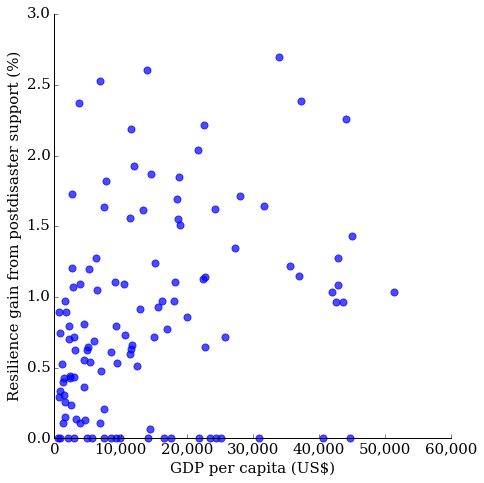

In [11]:
couleur = ("blue","red","green","yellow","purple")
coul = "blue"
option = "unif_poor"
ref = compute_resilience(macro,cat_info,optionPDS="no",**args)
plt.figure(figsize=(7,7))
#for option,coul in zip(listePDS,couleur):
#    print(option
dfr = compute_resilience(macro,cat_info,optionPDS=option,optionT="data",optionB="data",**args)
diff = 100*(dfr.resilience-ref.resilience)
plt.scatter(results.gdp_pc_pp,diff,color=coul,alpha=.7,s=50, clip_on=False)


#plt.legend(listePDS)
plt.xlabel("GDP per capita (US$)")
plt.ylabel("Resilience gain from postdisaster support (%)")
#plt.legend(["Uniform support", "Support proportional to losses"])
plt.xlim(xmin=0)
plt.ylim(0)


spine_and_ticks(plt.gca())
x_thousands_sep()

savefig("img/resilience_gain_post-disaster_support.png")


print('Average (population weights) (',option,')',((diff*dfr["pop"]).sum())/dfr["pop"].sum())
print('Average (no weights) (',option,')',((diff.mean())))
print('Country where post-disaster support reduces resilience')
results["diff"]=diff
print(results.query("diff<0")["diff"])
print('Benefits')
print((ref.dWtot_currency.sum()-dfr.dWtot_currency.sum())/1e9)
print('No PDS')
a=results.resilience;
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= ref.dWtot_currency.sum()*1e-9,
k= ref.dKtot.sum()*1e-9,
r=ref.dWtot_currency.sum()/results.dKtot.sum()))
print('PDS cost:',((ref["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print('resilience:',ref.dKtot.sum()/ref.dWtot_currency.sum())
print('With PDS')
print('PDS cost:',((dfr["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= dfr.dWtot_currency.sum()*1e-9,
k= dfr.dKtot.sum()*1e-9,
r=dfr.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience:',dfr.dKtot.sum()/dfr.dWtot_currency.sum())
print('resilience gain:',dfr.dKtot.sum()/dfr.dWtot_currency.sum()-ref.dKtot.sum()/ref.dWtot_currency.sum())


### Why is post-disaster support unable to increase resilience in some countries?

(0, 1)

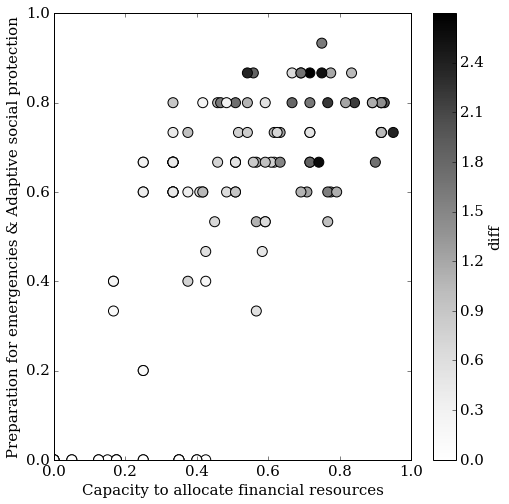

In [12]:
plt.figure(figsize=(8,8))
ax = plt.gca();
#dfr["diff"]=(diff>1)*1 + (diff<=0)*0
dfr["diff"]=diff
dfr.plot.scatter(x="borrow_abi",y="prepare_scaleup",c="diff",s = 100 ,ax=ax)
plt.xlabel("Capacity to allocate financial resources")
plt.ylabel("Preparation for emergencies & Adaptive social protection")
plt.xlim(xmin=0,xmax=1)
plt.ylim(ymin=0,ymax=1)
#plt.legend('Increase in resilience')

## fixing that wth the PDS package

In [13]:
from apply_policy import apply_policy

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Develop contingent finance and reserve funds
Make social protection scalable after a shock
Postdisaster support package
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Average (population weights) ( unif_poor ) 1.3717549579929207
Average (no weights) ( unif_poor ) 1.95525243072577
Country where post-disaster support reduces resilience
Series([], Name: diff, dtype: float64)
Benefits
12.550952127061585
No PDS
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.6 times bigger, at 517 bn$ per year
PDS cost: 11.049155337233886
resilience: 0.6330070746372456
With PDS
PDS cost: 23.007982886516807
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio eco

country
Angola                      9.731354
Congo, Dem. Rep.            5.990810
Benin                       5.656408
Gabon                       4.763448
Central African Republic    4.338968
Lesotho                     3.847832
Nepal                       3.775456
Name: resilience, dtype: float64

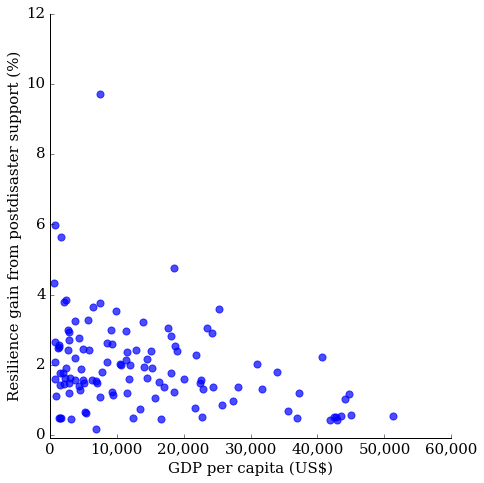

In [14]:
couleur = ("blue","red","green","yellow","purple")
coul = "blue"
option = "unif_poor"
ref = compute_resilience(macro,cat_info,**args)
plt.figure(figsize=(7,7))
#for option,coul in zip(listePDS,couleur):
#    print(option

m,c,h,a,desc = apply_policy(macro,cat_info,macro*0, args, policy_name="PDSpackage", verbose=True)

dfr = compute_resilience(m,c,optionPDS=option,optionT="data",optionB="data",**a)
diff = 100*(dfr.resilience-ref.resilience)
plt.scatter(results.gdp_pc_pp,diff,color=coul,alpha=.7,s=50)
#plt.legend(listePDS)
plt.xlabel("GDP per capita (US$)")
plt.ylabel("Resilience gain from postdisaster support (%)")
#plt.legend(["Uniform support", "Support proportional to losses"])
plt.xlim(xmin=0)
plt.ylim(ymin=-.1)


spine_and_ticks(plt.gca())
x_thousands_sep()

savefig("img/resilience_gain_post-disaster_support_PDS_package.png")


print('Average (population weights) (',option,')',((diff*dfr["pop"]).sum())/dfr["pop"].sum())
print('Average (no weights) (',option,')',((diff.mean())))
print('Country where post-disaster support reduces resilience')
results["diff"]=diff
print(results.query("diff<0")["diff"])
print('Benefits')
print((ref.dWtot_currency.sum()-dfr.dWtot_currency.sum())/1e9)
print('No PDS')
a=results.resilience;
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= ref.dWtot_currency.sum()*1e-9,
k= ref.dKtot.sum()*1e-9,
r=ref.dWtot_currency.sum()/results.dKtot.sum()))
print('PDS cost:',((ref["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print('resilience:',ref.dKtot.sum()/ref.dWtot_currency.sum())
print('With PDS')
print('PDS cost:',((dfr["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= dfr.dWtot_currency.sum()*1e-9,
k= dfr.dKtot.sum()*1e-9,
r=dfr.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience GLOBALLY:',dfr.dKtot.sum()/dfr.dWtot_currency.sum())
print('resilience gain GLOBALLY:',dfr.dKtot.sum()/dfr.dWtot_currency.sum()-ref.dKtot.sum()/ref.dWtot_currency.sum())


diff.sort_values(ascending=False).head(7)

## What if post-disaster support was an insurance? 
here insurance modeled as a post-disaster transfer covering 80% of losses, paid through taxes (as a proxy for risk-based premium)

In [15]:
args = dict(return_stats=True, hazard_ratios=hazard_ratios)

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Develop market insurance (nonpoor people)
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,need,shew,social,v,v_shew
shareable 0.25
Average (population weights) ( prop_nonpoor ) 3.8636978515843343
Average (no weights) ( prop_nonpoor ) 3.2048874141860417
Country where post-disaster support reduces resilience
Series([], Name: diff, dtype: float64)
Series([], Name: diff2, dtype: float64)
Benefits
30.560111699043212
No PDS
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.6 times bigger, at 529 bn$ per year
resilience: 0.61894161799855
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.5 times bigger, at 499 bn$ per year
PDS co

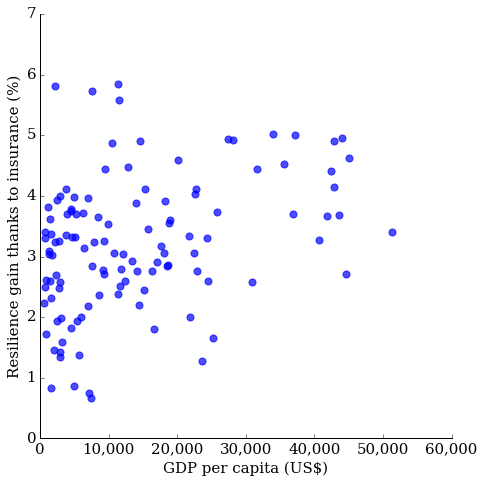

In [16]:
couleur = ("blue","red","green","yellow","purple")
coul = "blue"


shareable = .25


ref = compute_resilience(macro,cat_info,optionPDS="no",**args)
plt.figure(figsize=(7,7))
option = "prop_nonpoor"
#for option,coul in zip(listePDS,couleur):
#    print(option

m,c,h,a,desc = apply_policy(macro,cat_info,macro*0, args, policy_name="prop_nonpoor", verbose=True)

# dfr, ciah = compute_resilience(m,c,**a)

dfr = compute_resilience(m,c,**a)

diff = 100*(dfr.resilience - ref.resilience)
diff2 = -(dfr.dWpc_currency - ref.dWpc_currency)
plt.scatter(results.gdp_pc_pp,diff,color=coul,alpha=.7,s=50)
#plt.legend(listePDS)
plt.xlabel("GDP per capita (US$)")
plt.ylabel("Resilience gain thanks to insurance (%)")
#plt.legend(["Uniform support", "Support proportional to losses"])
plt.xlim(xmin=0)
plt.ylim(ymin=0)



spine_and_ticks(plt.gca())

x_thousands_sep()

savefig("img/gains_of_insurance_shareable{s}.png".format(s=shareable))


# plt.ylim(0,6)

# savefig("img/gains_of_insurance_shareable{s}_shaved.png".format(s=shareable))



print("shareable", shareable)
print('Average (population weights) (',option,')',((diff*dfr["pop"]).sum())/dfr["pop"].sum())
print('Average (no weights) (',option,')',((diff.mean())))
print('Country where post-disaster support reduces resilience')
results["diff"]=diff
results["diff2"]=diff2
print(results.query("diff<0")["diff"])
print(results.query("diff2<0")["diff2"])
print('Benefits')
print((ref.dWtot_currency.sum()-dfr.dWtot_currency.sum())/1e9)
print('No PDS')
a=results.resilience;
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= ref.dWtot_currency.sum()*1e-9,
k= ref.dKtot.sum()*1e-9,
r=ref.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience:',ref.dKtot.sum()/ref.dWtot_currency.sum())
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= dfr.dWtot_currency.sum()*1e-9,
k= dfr.dKtot.sum()*1e-9,
r=dfr.dWtot_currency.sum()/results.dKtot.sum()))
print('PDS cost:',((dfr["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print('resilience:',dfr.dKtot.sum()/dfr.dWtot_currency.sum())
print('resilience gain:',dfr.dKtot.sum()/dfr.dWtot_currency.sum()-ref.dKtot.sum()/ref.dWtot_currency.sum())

print(diff.argmax(),diff.max())

## Resilience gains if budget constraints were released (only 5% of GDP limit) - proportional distribution

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Average (population weights)  1.2308180826386104
Average (no weights)  1.7153979843184681
Country where higher budget for post-disaster support reduces resilience
Country where more resources would reduce resilience
Empty DataFrame
Columns: [diff]
Index: []
Country where more resources would increase resilience the most
                              diff
country                           
Angola                    5.311727
Benin                     4.803258
Congo, Dem. Rep.          4.460242
Gabon                     3.677619
Lesotho                   3.412509
Central African Republic  3.349224
Swaziland                 3.304828
Estonia                   3.229025
El Salvador               3.225997
Nepal                     3.180235
Zambia                    2.994930
Gre

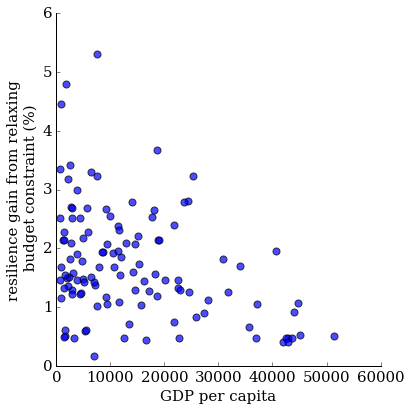

In [17]:
coul = ("blue")
ref = compute_resilience(macro,cat_info,optionPDS="unif_poor",optionT="data",optionB="data",**args)
#ref = 100*compute_resilience(macro,cat_info,**args,optionPDS="no").resilience
plt.figure(figsize=(6,6))
ax = plt.gca();
#for option,coul in zip(listePDS,couleur):
#    print(option
dfr = compute_resilience(macro,cat_info,optionPDS="unif_poor",optionT="data",optionB="max05",**args) 
dfr["diff"] = 100*(dfr.resilience - ref.resilience)


dfr.plot.scatter(x="gdp_pc_pp",y="diff",color=coul,alpha=.7,s=50,ax=ax)

#plt.legend(listePDS)
plt.xlabel("GDP per capita")
plt.ylabel("resilience gain from relaxing\n budget constraint (%)")
#plt.legend(["Uniform support", "Support proportional to losses"])
plt.xlim(xmin=0)
plt.ylim(ymin=0)

spine_and_ticks(ax)

savefig("img/resilience_gain_post-disaster_support_freebudget.png")


print('Average (population weights) ',((dfr["diff"]*ref["pop"]).sum())/ref["pop"].sum())
print('Average (no weights) ',((dfr["diff"].mean())))
print('Country where higher budget for post-disaster support reduces resilience')
print("Country where more resources would reduce resilience")
print(dfr.query("diff<0")[["diff"]])
print("Country where more resources would increase resilience the most")
print(dfr.sort_values("diff",ascending=False).head(20)[["diff"]])
print('Before')
print('PDS cost:',((ref["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
a=results.resilience;
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= ref.dWtot_currency.sum()*1e-9,
k= ref.dKtot.sum()*1e-9,
r=ref.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience:',ref.dKtot.sum()/ref.dWtot_currency.sum())
print('After')
print('PDS cost:',((dfr["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= dfr.dWtot_currency.sum()*1e-9,
k= dfr.dKtot.sum()*1e-9,
r=dfr.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience:',dfr.dKtot.sum()/dfr.dWtot_currency.sum())
print('resilience gain:',dfr.dKtot.sum()/dfr.dWtot_currency.sum()-ref.dKtot.sum()/ref.dWtot_currency.sum())


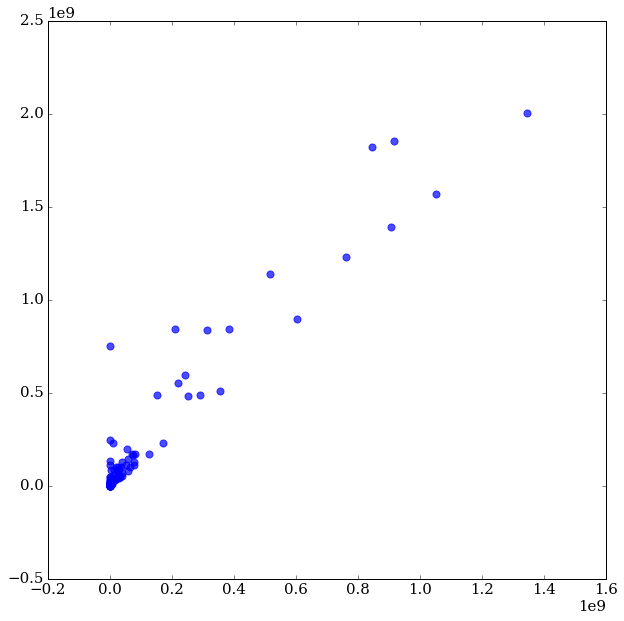

In [18]:
dfr["addfin"]=dfr["average_aid_cost_pc"]*dfr["pop"]
ref["addfin"]=ref["average_aid_cost_pc"]*ref["pop"]
plt.figure(figsize=(10,10))
ax = plt.gca();
plt.scatter(ref["addfin"],dfr["addfin"],color=coul,alpha=.7,s=50)
#plt.legend(listePDS)
#plt.legend(["Uniform support", "Support proportional to losses"])
#plt.xlim(xmin=0)
#plt.ylim(ymin=-1)

## Resilience gain if all countries can at least allocate 1% of GDP

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,need,shew,social,v,v_shew
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,need,shew,social,v,v_shew
Average (population weights)  2.5755874755502264
Average (no weights)  3.9595759492107385
Country where higher budget for post-disaster support reduces resilience
Country where more resources would reduce resilience
Empty DataFrame
Columns: [diff]
Index: []
Country where more resources would increase resilience the most
                         diff
country                      
Thailand            29.751717
Russian Federation  22.572525
Guatemala           22.314321
Niger               17.039284
Estonia             16.698610
Iran, Islamic Rep.  15.389654
Macedonia, FYR      13.906694
Uzbekistan          13.524875
Mauritania          12.323255
Tajikistan          11.823692
Turkey              11.798152
Poland              10.855677
Latvia              10.67811

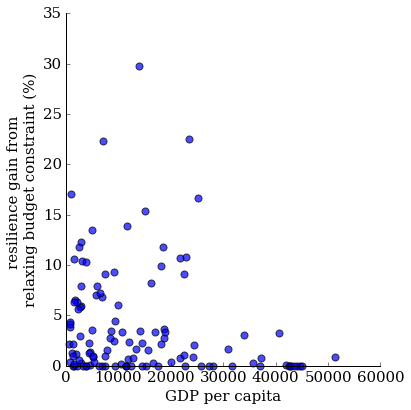

In [19]:
coul = ("blue")
ref = compute_resilience(macro,cat_info,optionPDS="prop",optionT="data",optionB="data",**args)
#ref = 100*compute_resilience(macro,cat_info,**args,optionPDS="no").resilience
plt.figure(figsize=(6,6))
ax = plt.gca();
#for option,coul in zip(listePDS,couleur):
#    print(option
dfr = compute_resilience(macro,cat_info,optionPDS="prop",optionT="data",optionB="max01",**args) 
dfr["diff"] = 100*(dfr.resilience.dropna().clip(lower=ref.dropna().resilience) - ref.resilience.dropna())
dfr.plot.scatter(x="gdp_pc_pp",y="diff",color=coul,alpha=.7,s=50,ax=ax, clip_on=False)
#plt.legend(listePDS)
plt.xlabel("GDP per capita")
plt.ylabel("resilience gain from \nrelaxing budget constraint (%)")
#plt.legend(["Uniform support", "Support proportional to losses"])
plt.xlim(xmin=0)
plt.ylim(ymin=0)

spine_and_ticks(ax)

plt.savefig("img/resilience_gain_post-disaster_support_freebudget.png")




print('Average (population weights) ',((dfr["diff"]*ref["pop"]).sum())/ref["pop"].sum())
print('Average (no weights) ',((dfr["diff"].mean())))
print('Country where higher budget for post-disaster support reduces resilience')
print("Country where more resources would reduce resilience")
print(dfr.query("diff<0")[["diff"]])
print("Country where more resources would increase resilience the most")
print(dfr.sort_values("diff",ascending=False).head(20)[["diff"]])
print('Before')
print('PDS cost:',((ref["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
a=results.resilience;
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= ref.dWtot_currency.sum()*1e-9,
k= ref.dKtot.sum()*1e-9,
r=ref.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience:',ref.dKtot.sum()/ref.dWtot_currency.sum())
print('After')
print('PDS cost:',((dfr["average_aid_cost_pc"]*dfr["pop"]).sum()/1e9))
print("At the global scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. But due to lack of socio economic capacity, welfare losses are {r:.1f} times bigger, at {w:.0f} bn$ per year".format( 
w= dfr.dWtot_currency.sum()*1e-9,
k= dfr.dKtot.sum()*1e-9,
r=dfr.dWtot_currency.sum()/results.dKtot.sum()))
print('resilience:',dfr.dKtot.sum()/dfr.dWtot_currency.sum())
print('resilience gain:',dfr.dKtot.sum()/dfr.dWtot_currency.sum()-ref.dKtot.sum()/ref.dWtot_currency.sum())


In [20]:
#bad=results.query("diff<0")
#bad["ebias"] = (cat_info.unstack("income_cat")["fa"]["poor"]/cat_info.unstack("income_cat")["fa"]["nonpoor"])
#bad["vbias"] = (cat_info.unstack("income_cat")["v"]["poor"]/cat_info.unstack("income_cat")["v"]["nonpoor"])
#bad=bad.query("diff<0")
#bad

# Benefit-cost ratio of post-disaster support

## BC ratio of one dollar per affected people, with and without cost of public resources

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew


C:\Users\Admin\Box Sync\PYTHON - RESILIENCE\resilience_indicator_multihazard\res_ind_lib.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d["un"]=1


stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Average (population weights) ( prop_nonpoor ) 2.270150253268013
Average (no weights) ( prop_nonpoor ) 2.2630176517522305
Countries where post-disaster support has BC ratio < 1 ( prop_nonpoor )
Series([], Name: bcr025, dtype: float64)
Country where more resources would increase resilience the most
country
South Africa                5.706374
Zambia                      5.522412
Honduras                    5.516887
Lesotho                     5.466671
Botswana                    5.343034
Panama                      4.988080
Brazil                      4.574090
Colombia                    4.344863
Central African Republic    4.336346
Bolivia                     4.053694
Kenya                       3.706788
Angola                      3.617500
Swaziland                   3.540729
Paraguay                    3.388076
Ecuador                     3.296953
Congo, Dem. Rep.            3

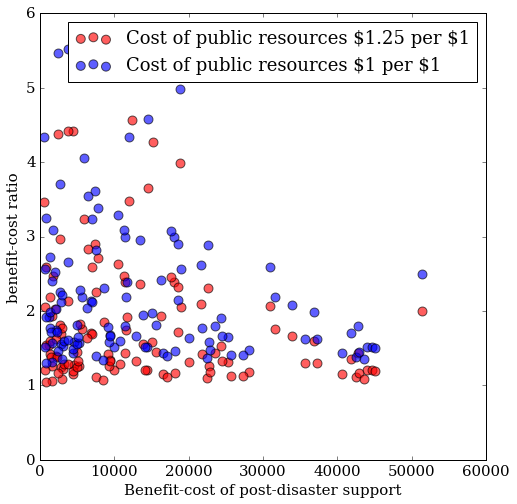

In [21]:
# metrics is the benefit-cost ratio of post-disaster support')
# always >1 for unif_poor - a few countries with <1 with prop

fig=plt.figure(figsize=(8,8));
ax = plt.gca();
optionPDS = "unif_poor"
optionB = "one_per_affected"
no = compute_resilience(macro,cat_info,optionPDS="no",**args)


dfr,dfr_iah = compute_resilience(macro,cat_info, return_iah=True, optionPDS=optionPDS, optionT="data",optionB=optionB,fraction_inside=0,**args)
dfr["benefit-cost ratio"] = -(dfr.dWpc_currency - no.dWpc_currency)/dfr["average_aid_cost_pc"] 
dfr["bcr"] = -(dfr.dWpc_currency - no.dWpc_currency)/dfr["average_aid_cost_pc"]
dfr["bcr025"] = -(dfr.dWpc_currency - no.dWpc_currency)/(1.25*dfr["average_aid_cost_pc"])

dfr.plot.scatter(
    x="gdp_pc_pp", y="bcr025", c= 'red', s=80, alpha=.63, ax=ax)
dfr.plot.scatter(
    x="gdp_pc_pp", y="benefit-cost ratio", c='blue', s=80, alpha=.63, ax=ax)

print('Average (population weights) (',option,')',((dfr["benefit-cost ratio"]*dfr["pop"]).sum())/dfr["pop"].sum())
print('Average (no weights) (',option,')',((dfr["benefit-cost ratio"].mean())))
print('Countries where post-disaster support has BC ratio < 1 (',option,')')
print((dfr.query("bcr025<1")).bcr025)
    
#plt.title("Perfect targeting")
plt.legend(['Cost of public resources \$1.25 per \$1','Cost of public resources \$1 per \$1'])
plt.xlim(0)
plt.xlabel("GDP per capita")
plt.xlabel("Benefit-cost of post-disaster support")
plt.savefig("benefit-cost-ratio-post-disaster-support.png")
print("Country where more resources would increase resilience the most")
print(dfr.sort_values("bcr",ascending=False).head(20)["bcr"])

## Looking at the benefit-cost ratio of $1 in support, given to each affected person (with and without targeting error)

stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
Average (population weights) ( x33 ) 2.1982697613749083
Average (no weights) ( x33 ) 2.224372828536163
Countries where post-disaster support has BC ratio < 1 ( x33 )
Series([], Name: bcr, dtype: float64)
Country with highest benefit-cost ratio
country
South Africa                5.596590
Honduras                    5.520076
Lesotho                     5.420359
Botswana                    5.186866
Zambia                      4.891067
Panama                      4.743673
Central African Republic    4.621799
Brazil                      4.269653
Colombia                    4.182262
Angola                      4.151261
Bolivia                     3.997023
Swaziland  

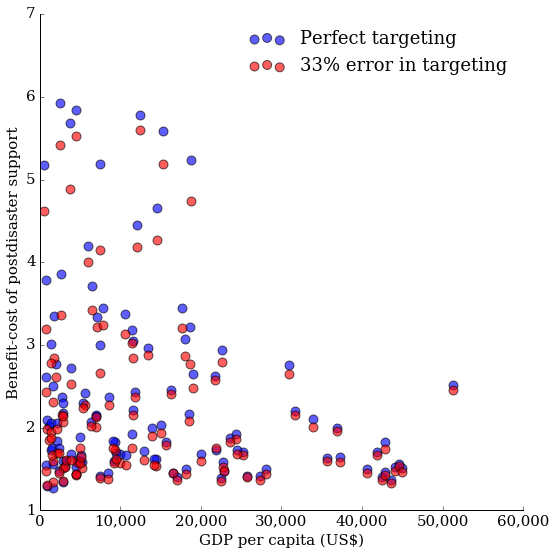

In [22]:
# metrics is the benefit-cost ratio of post-disaster support')
# always >1 for unif_poor - a few countries with <1 with prop

fig=plt.figure(figsize=(8,8));
ax = plt.gca();
listeT = ("perfect","x33") #,"excl","incl") #,"20","incl")
opt_leg = ("Perfect targeting","33% error in targeting") #,"33% exclusion error", "33% inclusion error")
couleur = ("blue","red","green","yellow","purple")
no = compute_resilience(macro,cat_info,optionPDS="no",**args)

for option,coul in zip(listeT,couleur):
    dfr,dfr_iah = compute_resilience(macro,cat_info, return_iah=True, optionPDS="one", optionT=option,optionB="data",fraction_inside=0,**args)
    dfr["benefit-cost ratio"] = -(dfr.dWpc_currency - no.dWpc_currency)/dfr["average_aid_cost_pc"] 
    dfr["bcr"] = -(dfr.dWpc_currency - no.dWpc_currency)/dfr["average_aid_cost_pc"]
    dfr["bcr025"] = -(dfr.dWpc_currency - no.dWpc_currency)/(1.25*dfr["average_aid_cost_pc"])

    dfr.plot.scatter(
        x="gdp_pc_pp", y="bcr", c= coul, s=80, alpha=.63, ax=ax)
    
    
    
    
    
#dfr.plot.scatter(
#    x="gdp_pc_pp", y="benefit-cost ratio", c='blue', s=80, alpha=.63, ax=ax)

print('Average (population weights) (',option,')',((dfr["benefit-cost ratio"]*dfr["pop"]).sum())/dfr["pop"].sum())
print('Average (no weights) (',option,')',((dfr["benefit-cost ratio"].mean())))
print('Countries where post-disaster support has BC ratio < 1 (',option,')')
print((dfr.query("bcr<1")).bcr)
    
#plt.title("Perfect targeting")
#plt.legend(['Cost of public resources \$1.25 per \$1','Cost of public resources \$1 per \$1'])
plt.legend(opt_leg, frameon=False)
plt.xlim(0)
plt.xlabel("GDP per capita (US$)")
plt.ylabel("Benefit-cost of postdisaster support")
x_thousands_sep()

spine_and_ticks(plt.gca())

savefig("img/benefit-cost-ratio-post-disaster-support.png")
print("Country with highest benefit-cost ratio")
print(dfr.sort_values("bcr",ascending=False).head(20)["bcr"])
print("Country with lowest benefit-cost ratio")
print(dfr.sort_values("bcr",ascending=True).head(20)["bcr"])

## Proportional transfers or uniform transfer? How much gain in BC ratio?

In [23]:
print ('A better metrics is the benefit-cost ratio of post-disaster support')
# always >1 for unif_poor - a few countries with <1 with prop

modalities_and_color = dict(
  #             no      ="#386cb0",
  #              unif_all="#f0027f",
                unif_poor   ="#beaed4",
                prop    ="#7fc97f",
                            )



no = compute_resilience(macro,cat_info,optionPDS="no",**args)

dfr1,dfr1_iah = compute_resilience(macro,cat_info,return_iah=True, optionPDS="unif_poor", optionT="perfect",optionB="one_per_affected",fraction_inside=0,**args)
dfr2,dfr2_iah = compute_resilience(macro,cat_info,return_iah=True, optionPDS="prop", optionT="perfect",optionB="one_per_affected",fraction_inside=0,**args)
dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]


diff = dfr1["bcr"] - dfr2["bcr"]
dfr2["diff"]=diff

#dfr1.plot.scatter(x="gdp_pc_pp", y="bcr", color = 'blue', s=80, alpha=.63, ax=ax)
#dfr2.plot.scatter(x="gdp_pc_pp", y="bcr", color = 'red', s=80, alpha=.63, ax=ax)
# dfr2.plot.scatter(x="gdp_pc_pp", y="diff", color = 'red', s=80, alpha=.63, ax=ax)
 




A better metrics is the benefit-cost ratio of post-disaster support
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew


C:\Users\Admin\Box Sync\PYTHON - RESILIENCE\resilience_indicator_multihazard\res_ind_lib.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d["un"]=1


stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,need,shew,social,v,v_shew


In [24]:

one_large = dfr1[dfr1["bcr"]>dfr2["bcr"]].index
two_large = dfr1[dfr1["bcr"]<dfr2["bcr"]].index

Average (population weights) (unif_poor) 2.3245890114997123
Average (no weights) (unif_poor) 2.3580711428167285
Countries where post-disaster support has BC ratio < 1 (unif_poor)
Series([], Name: bcr, dtype: float64)
Average (population weights) (prop) 1.396172297996256
Average (no weights) (prop) 1.4827257106977503
Countries where post-disaster support has BC ratio < 1 (prop)
country
Azerbaijan    0.919156
Georgia       0.837412
Hungary       0.981500
Ireland       0.981691
Name: bcr, dtype: float64
Where proportional is better
country
Cambodia     -0.138840
Greece       -0.052586
Mali         -0.449820
Mauritania   -0.555578
Niger        -0.529934
Thailand     -0.898532
Name: diff, dtype: float64
20 Best countries where to use uniform
country
South Africa                4.708910
Lesotho                     4.140183
Botswana                    4.060962
Honduras                    4.013124
Panama                      3.445439
Central African Republic    3.364061
Zambia                 

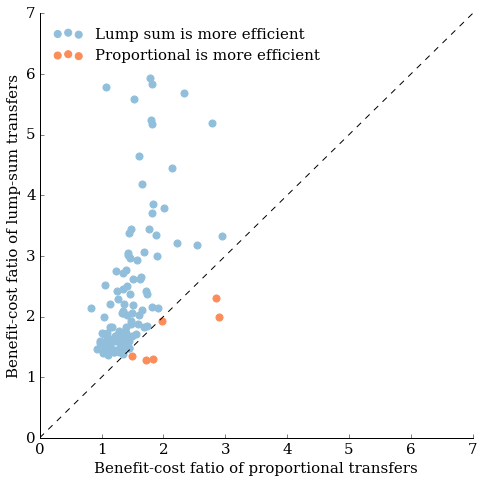

In [25]:
fig=plt.figure(figsize=(7,7));
ax = plt.gca();

# ax.scatter(y=dfr1["bcr"], x=dfr2["bcr"], s=50, alpha=0.5, clip_on=False)   

ax.scatter(y=dfr1.ix[one_large,"bcr"], x=dfr2.ix[one_large,"bcr"], s=50,  clip_on=False, color="#91bfdb")   
ax.scatter(y=dfr1.ix[two_large,"bcr"], x=dfr2.ix[two_large,"bcr"], s=50, clip_on=False, color = "#fc8d59")   

plt.legend(["Lump sum is more efficient", "Proportional is more efficient"], prop=font, frameon=False, loc=2)

plt.plot([0,7],[0,7], "--", color="black")

    
print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
print((dfr1.query("bcr<1")).bcr)
    
print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
print('Countries where post-disaster support has BC ratio < 1 (prop)')
print((dfr2.query("bcr<1")).bcr)


print("Where proportional is better")
print((dfr2.query("diff<0"))["diff"])

print("20 Best countries where to use uniform")
print(dfr2.sort_values("diff",ascending=False).head(20)["diff"])

print(diff.mean())
    
#plt.legend(['Uniform transfer','Transfer proportional to losses'])
plt.ylabel("Benefit-cost fatio of lump-sum transfers")
plt.xlabel("Benefit-cost fatio of proportional transfers")
plt.xlim(0,7)
plt.ylim(0,7)

spine_and_ticks(plt.gca())
# x_thousands_sep()

savefig("img/benefit-cost-ratio-post-disaster-support-one-dol.png")

In [26]:
print(dfr1.ix["Bangladesh"][["bcr"]])
print(dfr1.ix["Bangladesh"][["bcr"]])
print(dfr2.ix["Bangladesh"][["bcr"]])
dfr["average_aid_cost_pc"]*dfr2["pop"]

bcr    1.597644
Name: Bangladesh, dtype: float64
bcr    1.597644
Name: Bangladesh, dtype: float64
bcr    1.401772
Name: Bangladesh, dtype: float64


country
Albania                     1.394793e+04
Angola                      3.312503e+04
Argentina                   1.279456e+05
Armenia                     3.366565e+04
Australia                   2.984042e+04
Austria                     1.992088e+04
Azerbaijan                  6.254471e+04
Bangladesh                  2.760886e+06
Belarus                     4.891118e+04
Belgium                     5.743794e+03
Benin                       1.678763e+04
Bolivia                     6.009191e+04
Bosnia and Herzegovina      1.672610e+04
Botswana                    2.860916e+03
Brazil                      1.628553e+05
Bulgaria                    1.436782e+04
Burkina Faso                2.543663e+04
Burundi                     4.026585e+04
Cambodia                    5.391885e+05
Cameroon                    9.559905e+04
Canada                      4.824191e+04
Central African Republic    1.302822e+04
Chad                        3.541472e+04
Chile                       4.985328e+05
China   

## BC ratio with proportional and uniform transfers

In [27]:
modalities_and_color = dict(
  #             no      ="#386cb0",
  #              unif_all="#f0027f",
                unif_poor   ="#beaed4",
                prop    ="#7fc97f",
                            )
fig=plt.figure(figsize=(8,8));
ax = plt.gca();

no = compute_resilience(macro,cat_info,**args,optionPDS="no")
dfr1,dfr1_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS="unif_poor", optionT="perfect",optionB="one_per_affected",fraction_inside=0)
dfr2,dfr2_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS="prop", optionT="perfect",optionB="one_per_affected",fraction_inside=0)
dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]

diff = dfr1["bcr"] - dfr2["bcr"]
dfr2["diff"]=diff

dfr1.plot.scatter(x="gdp_pc_pp", y="bcr", color = 'blue', s=80, alpha=.63, ax=ax)
dfr2.plot.scatter(x="gdp_pc_pp", y="bcr", color = 'red', s=80, alpha=.63, ax=ax)
    
print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
print((dfr1.query("bcr<1")).bcr)
    
print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
print('Countries where post-disaster support has BC ratio < 1 (prop)')
print((dfr2.query("bcr<1")).bcr)
    
plt.legend(['Uniform transfer','Transfer proportional to losses'])
plt.xlabel("GDP per capita")
plt.ylabel("Benefit-cost ratio")
plt.xlim(xmin=0)
plt.ylim(ymax=8)
plt.savefig("benefit-cost-ratio-post-disaster-support-one-dol-prop-and-unif.png")

SyntaxError: invalid syntax (<ipython-input-27-6959c70861f5>, line 10)

# Exploring targeting errors further

In [ ]:
listePDS = ("no","unif_all","unif_poor","prop")
listeT = ("data","perfect","excl","incl") #,"20","incl")
couleur = ("blue","red","green","yellow","purple")
plt.figure(figsize=(12,12))
optionPDS="unif_poor"
ref = 100*compute_resilience(macro,cat_info,**args,optionPDS="no").resilience
#ref = 100*compute_resilience(macro,cat_info,**args,optionPDS="no").resilience
for option,coul in zip(listeT,couleur):
    plt.scatter(results.gdp_pc_pp,100*compute_resilience(macro,cat_info,**args,optionPDS="prop",optionT=option,optionB="data").resilience-ref,color=coul,alpha=.7,s=50)
plt.legend(listeT)
plt.xlabel("GDP per capita")
plt.ylabel("resilience (%)")
plt.xlim(xmin=0)
#plt.ylim(ymin=-50,ymax=50)

In [ ]:
listePDS = ("no","unif_all","unif_poor","prop")
listeT = ("data","excl","incl") #,"20","incl")
couleur = ("blue","red","green","yellow","purple")
plt.figure(figsize=(12,12))
optionPDS="unif_poor"
ref = 100*compute_resilience(macro,cat_info,**args,optionPDS="unif_poor",optionT="perfect",optionB="unif_poor").resilience
for option,coul in zip(listeT,couleur):
    plt.scatter(results.gdp_pc_pp,100*compute_resilience(macro,cat_info,**args,optionPDS="unif_poor",optionT=option,optionB="unif_poor").resilience-ref,color=coul,alpha=.7,s=50)
plt.legend(listeT)
plt.xlabel("GDP per capita")
plt.ylabel("resilience (%)")
plt.xlim(xmin=0)
#plt.ylim(ymin=-50,ymax=50)

In [ ]:
print('Resilience gains from $1 per capita of post-disaster support depend on exposure')
plt.figure(figsize=(8,8))
ax = plt.gca();
no = compute_resilience(macro,cat_info,**args,optionPDS="no")
dfr = compute_resilience(macro,cat_info,**args,optionPDS="unif_poor",optionT="perfect",optionB="one")
dfr["Resiliencegains"]= 100*(dfr.resilience - no.resilience)
dfr["Exposure"]=dfr.fa #np.log(dfr.fa)
dfr["Resilience gains"]=dfr["Resiliencegains"]
dfr.query("Resiliencegains>0").plot.scatter(x="Exposure", y="Resilience gains",  s=80, alpha=.63, ax=ax, logy=True , logx= True)


# note that resilience gains non correlated with risk to asset or to welfare

import statsmodels.api as sm
import statsmodels.formula.api as smf
dfr["lr"]=np.log(dfr.Resiliencegains)
dfr["le"]=np.log(dfr.Exposure)
#lm = smf.ols(formula='Resiliencegains ~ Exposure', data=dfr).fit()
lm = smf.ols(formula='lr ~ le', data=dfr).fit()
# print the coefficients
print(lm.summary())
dfr["estrg"]=np.exp(dfr["le"]*lm.params[1] + lm.params[0]).dropna()
#X_new = pd.DataFrame({'le':[0, 0.2]})
#preds = lm.predict(dfr.le.values)
#plt.figure(figsize=(8,8))
dfr.plot(x="Exposure", y="estrg", c='red',  ax=ax, logy=True , logx= True)

plt.xlim(-0.005,.025)
plt.ylim(-0.5,10)

## BC ratio with and without targeting errors - with $1 per inhabitant and proportional transfers

In [ ]:
listeT = ("x33","excl","incl") #,"20","incl")
opt_leg = ("33% error in targeting", "33% exclusion error", "33% inclusion error")
couleur = ("red","green","yellow","purple")
optionPDS = "prop"

fig=plt.figure(figsize=(8,8));
ax = plt.gca();

no = compute_resilience(macro,cat_info,**args,optionPDS="no")

for option,coul in zip(listeT,couleur):
    dfr1,dfr1_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS=optionPDS, optionT="perfect",optionB="one_per_affected",fraction_inside=0)
    dfr2,dfr2_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS=optionPDS, optionT=option,optionB="one_per_affected",fraction_inside=0)
    dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
    dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]
    dfr2["diff"] = - dfr1["bcr"] + dfr2["bcr"]
    dfr2.plot.scatter(x="gdp_pc_pp", y="diff", color = coul, s=80, alpha=.63, ax=ax)
    print('Countries where cost of poor targeting > 25 cents a dollar')
    print(dfr2.query("diff < -0.25")[["diff","bcr"]])
    #print(dfr.sort_values("bcr",ascending=False).head(20)["bcr"])
    
#print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
#print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
#print((dfr1.query("bcr<1")).bcr)
    
#print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
#print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (prop)')
#print((dfr2.query("bcr<1")).bcr)

#print((dfr2.query("diff<0"))["diff"])

#print(diff.mean())
    
plt.legend(opt_leg , loc=3)
plt.title("Transfers proportional to losses")
plt.xlabel("GDP per capita")
plt.ylabel("Difference in benefit-cost ratio")
plt.savefig("benefit-cost-ratio-targeting-error_prop.png")

## BC ratio with and without targeting errors - with $1 per inhabitant and uniform transfers


In [ ]:
listeT = ("x33","excl","incl") #,"20","incl")
opt_leg = ("33% error in targeting", "33% exclusion error", "33% inclusion error")
couleur = ("red","green","yellow","purple")
optionPDS = "unif_poor"

fig=plt.figure(figsize=(8,8));
ax = plt.gca();

no = compute_resilience(macro,cat_info,**args,optionPDS="no")

for option,coul in zip(listeT,couleur):
    dfr1,dfr1_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS=optionPDS, optionT="perfect",optionB="one_per_affected",fraction_inside=0)
    dfr2,dfr2_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS=optionPDS, optionT=option,optionB="one_per_affected",fraction_inside=0)
    dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
    dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]
    dfr2["diff"] = - dfr1["bcr"] + dfr2["bcr"]
    dfr2.plot.scatter(x="gdp_pc_pp", y="diff", color = coul, s=80, alpha=.63, ax=ax)
    print('Countries where cost of poor targeting > 25 cents a dollar')
    print(dfr2.query("diff < -0.25")[["diff","bcr"]])
    
#print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
#print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
#print((dfr1.query("bcr<1")).bcr)
    
#print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
#print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (prop)')
#print((dfr2.query("bcr<1")).bcr)

#print((dfr2.query("diff<0"))["diff"])

#print(diff.mean())
    
plt.legend(opt_leg , loc=3)
plt.xlabel("GDP per capita")
plt.ylabel("Difference in benefit-cost ratio")
plt.title("Uniform transfers")
plt.savefig("benefit-cost-ratio-targeting-error_uf.png")


## Comparing BC ratio with and without targeting errors with $1 per affect person

In [ ]:
listeT = ("x33","excl","incl") #,"20","incl")
opt_leg = ("33% error in targeting", "33% exclusion error", "33% inclusion error")
couleur = ("red","green","yellow","purple")
listPDS = ("prop","unif_poor")

fig=plt.figure(figsize=(8,8));
ax = plt.gca();

no = compute_resilience(macro,cat_info,**args,optionPDS="no")

for optionPDS in listPDS:
    for option,coul in zip(listeT,couleur):
        dfr1,dfr1_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS=optionPDS, optionT="perfect",optionB="one_per_affected",fraction_inside=0)
        dfr2,dfr2_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS=optionPDS, optionT=option,optionB="one_per_affected",fraction_inside=0)
        dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
        dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]
        dfr2["diff"] = - dfr1["bcr"] + dfr2["bcr"]
        plt.scatter(dfr1["bcr"], dfr2["bcr"], color = coul, s=80, alpha=.63)
#        print('Countries where cost of poor targeting > 25 cents a dollar')
#        print(dfr2.query("diff < -0.25")[["diff","bcr"]])
    
#print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
#print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
#print((dfr1.query("bcr<1")).bcr)
    
#print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
#print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (prop)')
#print((dfr2.query("bcr<1")).bcr)

#print((dfr2.query("diff<0"))["diff"])

#print(diff.mean())
    
plt.legend(opt_leg , loc=1)
plt.xlabel("Benefit-cost ratio with perfect targeting")
plt.ylabel("Benefit-cost ratio with targeting error")
plt.savefig("benefit-cost-ratio-targeting-error.png")


## Comparing BC ratio with and without targeting errors with current transfers

In [ ]:
listeT = ("x33","excl","incl") #,"20","incl")
opt_leg = ("33% error in targeting", "33% exclusion error", "33% inclusion error")
couleur = ("red","green","yellow","purple")
listPDS = ("prop","unif_poor")

fig=plt.figure(figsize=(8,8));
ax = plt.gca();

no = compute_resilience(macro,cat_info,optionPDS="no",**args)

for optionPDS in listPDS:
    for option,coul in zip(listeT,couleur):
        dfr1,dfr1_iah = compute_resilience(macro,cat_info,return_iah=True, optionPDS=optionPDS, optionT="perfect",optionB="data",fraction_inside=0,**args)
        dfr2,dfr2_iah = compute_resilience(macro,cat_info,return_iah=True, optionPDS=optionPDS, optionT=option,optionB="data",fraction_inside=0,**args)
        dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
        dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]
        dfr2["diff"] = - dfr1["bcr"] + dfr2["bcr"]
        plt.scatter(dfr1["bcr"], dfr2["bcr"], color = coul, s=80, alpha=.63)
#        print('Countries where cost of poor targeting > 25 cents a dollar')
#        print(dfr2.query("diff < -0.25")[["diff","bcr"]])
    
#print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
#print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
#print((dfr1.query("bcr<1")).bcr)
    
#print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
#print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (prop)')
#print((dfr2.query("bcr<1")).bcr)

#print((dfr2.query("diff<0"))["diff"])

#print(diff.mean())
    
plt.legend(opt_leg , loc=1)
plt.xlabel("Benefit-cost ratio with perfect targeting")
plt.ylabel("Benefit-cost ratio with targeting error")
plt.savefig("benefit-cost-ratio-targeting-error.png")


In [ ]:
## Comparing BC ratio with and without targeting errors with large transfers (5% of GDP)

In [ ]:
listeT = ("x33","excl","incl") #,"20","incl")
opt_leg = ("33% error in targeting", "33% exclusion error", "33% inclusion error")
couleur = ("red","green","yellow","purple")
listPDS = ("one")
optionB = "x05"
fig=plt.figure(figsize=(8,8));
ax = plt.gca();

no = compute_resilience(macro,cat_info,**args,optionPDS="no")

for option,coul in zip(listeT,couleur):
    dfr1,dfr1_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS="unif_poor", optionT="perfect",optionB=optionB,fraction_inside=0)
    dfr2,dfr2_iah = compute_resilience(macro,cat_info,**args,return_iah=True, optionPDS="unif_poor", optionT=option,optionB=optionB,fraction_inside=0)
    dfr1["bcr"] = -(dfr1.dWpc_currency - no.dWpc_currency)/dfr1["average_aid_cost_pc"]
    dfr2["bcr"] = -(dfr2.dWpc_currency - no.dWpc_currency)/dfr2["average_aid_cost_pc"]
    dfr2["diff"] = - dfr1["bcr"] + dfr2["bcr"]
    plt.scatter(dfr1["bcr"], dfr2["bcr"], color = coul, s=80, alpha=.63)
#        print('Countries where cost of poor targeting > 25 cents a dollar')
#        print(dfr2.query("diff < -0.25")[["diff","bcr"]])
    
#print('Average (population weights) (unif_poor)',((dfr1["bcr"]*dfr1["pop"]).sum())/dfr1["pop"].sum())
#print('Average (no weights) (unif_poor)',((dfr1["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (unif_poor)')
#print((dfr1.query("bcr<1")).bcr)
    
#print('Average (population weights) (prop)',((dfr2["bcr"]*dfr2["pop"]).sum())/dfr2["pop"].sum())
#print('Average (no weights) (prop)',((dfr2["bcr"].mean())))
#print('Countries where post-disaster support has BC ratio < 1 (prop)')
#print((dfr2.query("bcr<1")).bcr)

#print((dfr2.query("diff<0"))["diff"])

#print(diff.mean())
    
plt.legend(opt_leg , loc=1)
plt.xlabel("Benefit-cost ratio with perfect targeting")
plt.ylabel("Benefit-cost ratio with targeting error")
plt.savefig("benefit-cost-ratio-targeting-error-big.png")


# Double dividend

In [ ]:
ddiv = pd.read_csv("T_all (2).csv").dropna()
ddiv.sample(n=10)

In [ ]:
from fancy_plots import spine_and_ticks

In [ ]:
ddiv2 = ddiv.sort_values("proba")

#removes crazy point at p==0
ddiv2.ix[ddiv2.proba==0,["W1_rel","Weq_rel","Wopt_rel"]]=np.nan

ddiv2["proba"]   *=100
ddiv2["W1_rel"]  *=100
ddiv2["Weq_rel"] *=100
ddiv2["Wopt_rel"]*=100

fig, axarr = plt.subplots(1,3, figsize=(12,4) , sharey=True)

l=0

for r_fig in [0.04,0.08,0.12]:
        for eta_fig,col in zip([1.5,0.5],[ "#377eb8","#4daf4a"] ):#"#984ea3"
                ddiv2["eta_fig"]=eta_fig
                ddiv2["r_fig"]=r_fig
                cond = "(r==r_fig)&(eta==eta_fig)&(insu==0)&(v==0.25)"
                ddiv2.query(cond).plot(x="proba",y="Wopt_rel", ax=axarr[l],color=col, linewidth=2)

        ddiv2.query(cond).plot(x="proba",y="Weq_rel", ax=axarr[l] ,color="#e41a1c", linewidth=2)
        ddiv2.query(cond).plot(x="proba",y="W1_rel",style="--", ax=axarr[l]  ,color="black",  linewidth=2)
        
        #cond2 = "(r==r_fig)&(eta==eta_fig)&(insu==0.5)&(v==0.25)"
        #ddiv2.query(cond2).plot(x="proba",y="Wopt_rel", ax=axarr[k])
        #cond3 = "(r==r_fig)&(eta==eta_fig)&(insu==0)&(v==0.125)"
        #ddiv2.query(cond3).plot(x="proba",y="Wopt_rel", ax=axarr[k])
        axarr[l].legend_.remove()
        axarr[l].set_ylim(ymin=95,ymax=120)        
#         axarr[l].set_title("r={r:.0%}".format(r=r_fig), **font)
        axarr[l].set_xlabel("Probability (% per year)")
        axarr[l].set_ylabel("Expected consumption")
        
#         axarr[l].vlines(x=2,
#                         ymin=100,linestyles ="dotted",
#                         ymax=ddiv2.query("(r==r_fig)&(eta==1.5)&(insu==0)&(v==0.25)&(proba==2)").Wopt_rel.mean(),
#                         color="#cccccc")
                           
#         axarr[l].hlines(xmin=2,
#                         xmax=10,
#                         y=100,linestyles ="dotted",
#                         color="#cccccc")                   
                           
        spine_and_ticks(axarr[l])

        l += 1

        


axarr[0].legend(["Investment response (High risk aversion, $\eta=1.5$)", 
                 "Investment response (Low risk aversion, $\eta=0.5$)",
                "Investment response (No risk aversion, $\eta=0$)",
                "No investment response, avoided losses only",
    ],
                bbox_to_anchor=(0, -0.7, 1, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0, frameon=False, prop=font)
#axarr[0,0:2].legend(["Expected consumption with avoided losses only","Expected consumption with investment response (no risk aversion)","Expected consumption with investment response (risk aversion)"],bbox_to_anchor=(0., 1.22, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

plt.savefig("img/benefit_DRM_proba.png", bbox_inches="tight")
plt.savefig("img/benefit_DRM_proba.pdf", bbox_inches="tight")



In [ ]:
r_fig = .08

fig, axarr = plt.subplots(1,1, figsize=(7,7) , sharey=True)
axarr = [axarr]
l=0

for eta_fig,col in zip([1.5,0.5],[ "#377eb8","#4daf4a"] ):#"#984ea3"
        ddiv2["eta_fig"]=eta_fig
        ddiv2["r_fig"]=r_fig
        cond = "(r==r_fig)&(eta==eta_fig)&(insu==0)&(v==0.25)"
        ddiv2.query(cond).plot(x="proba",y="Wopt_rel", ax=axarr[l],color=col, linewidth=2)

ddiv2.query(cond).plot(x="proba",y="Weq_rel", ax=axarr[l] ,color="#e41a1c", linewidth=2)
ddiv2.query(cond).plot(x="proba",y="W1_rel",style="--", ax=axarr[l]  ,color="black",  linewidth=2)

#cond2 = "(r==r_fig)&(eta==eta_fig)&(insu==0.5)&(v==0.25)"
#ddiv2.query(cond2).plot(x="proba",y="Wopt_rel", ax=axarr[k])
#cond3 = "(r==r_fig)&(eta==eta_fig)&(insu==0)&(v==0.125)"
#ddiv2.query(cond3).plot(x="proba",y="Wopt_rel", ax=axarr[k])
axarr[l].legend_.remove()
axarr[l].set_ylim(ymin=95,ymax=120)        
#         axarr[l].set_title("r={r:.0%}".format(r=r_fig), **font)
axarr[l].set_xlabel("Probability (% per year)")
axarr[l].set_ylabel("Expected consumption")


axarr[0].legend(["Investment response (High risk aversion)", 
                 "Investment response (Low risk aversion)",
                "Investment response (No risk aversion)",
                "No investment response, avoided losses only",
    ],
#                 bbox_to_anchor=(0, -0.7, 1, .102),
                loc=1,
           ncol=1, mode="expand", borderaxespad=0, frameon=False, prop=font)
#axarr[0,0:2].legend(["Expected consumption with avoided losses only","Expected consumption with investment response (no risk aversion)","Expected consumption with investment response (risk aversion)"],bbox_to_anchor=(0., 1.22, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

spine_and_ticks(axarr[l])

plt.tight_layout()

plt.savefig("img/benefit_DRM_proba_08.png", bbox_inches="tight")
plt.savefig("img/benefit_DRM_proba_08.pdf", bbox_inches="tight")


In [ ]:
fig=plt.figure(figsize=(8,8));
ax = plt.gca();
ddiv2["p_before"] = 0.1*100
ddiv2["p_after"] = 0.02*100
cond = "(insu==0)&(v==0.25)&((proba==p_after))"
ddiv3 = ddiv2.query(cond).set_index("proba").rename({0.02: "after", 0.10:"before"})
ddiv3["Before"]=100
ddiv3["No risk aversion"] =  (ddiv3["Weq_rel"]-ddiv3["Before"]) / (ddiv3["W1_rel"]-ddiv3["Before"])
ddiv3["Risk aversion"] =  (ddiv3["Wopt_rel"]-ddiv3["Before"]) / (ddiv3["W1_rel"]-ddiv3["Before"])
ddiv3.boxplot(["No risk aversion","Risk aversion"],ax=ax)
plt.savefig("img/benefit_DRM_10_to_2.png")
ddiv3

In [ ]:
ddiv3.set_index(["r","eta"])